In this project we will train an agent that handles the landing of a spaceship with reinforcement learning!

In [1]:
!pip install swig

In [2]:
!pip install gymnasium[box2d]

In [3]:
!pip install renderlab

In [4]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 4.4 MB/s eta 0:00:00


# Base functions
1. step: performs an action in the enviroonment.

2. reset: resets the environment to its original state.

3. render: visualizes the environment.

# LunarLander-v3 descritpion

1. Observation Space describes the state of the object with 8 variables.

2. Action Space describes the action that can be taken with 4 values.

3. Reward Function is used to reward proper actions that lead to the desired outcome, like comfortable landing.

In [5]:
import renderlab as rl
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

  return datetime.utcnow().replace(tzinfo=utc)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [109]:
env = gym.make("LunarLander-v3",render_mode = "rgb_array")
env = rl.RenderFrame(env,"./output")
episodes=5
rewards=[]
for epis in range(episodes):
  observation, info = env.reset()
  score=0
  terminated=False
  truncated=False

  while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info= env.step(action)
    score= score+reward

    if terminated or truncated:
      break
  rewards.append(score)
  print(f'Epis {epis+1}: score = {score:.2f}')
env.play()
print(f'Avg score: {np.mean(rewards):.2f}')

Epis 1: score = -76.24
Epis 2: score = -142.69
Epis 3: score = -281.42
Epis 4: score = -157.21
Epis 5: score = -152.90
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Avg score: -162.09


We see low scores and a terrible landing procedure.

In [16]:
import time
import matplotlib.pyplot as plt

In [110]:
steps=10000

In [111]:
dqn_env = Monitor(gym.make("LunarLander-v3"))

In [112]:
dqn_model = DQN("MlpPolicy",dqn_env,verbose=0)

In [113]:
start_time = time.time()
dqn_model.learn(total_timesteps=steps)
dqn_time =time.time()-start_time
print(f'DNQ took {dqn_time:.2f} secs')

DNQ took 9.74 secs


In [114]:
ppo_env = Monitor(gym.make("LunarLander-v3"))
ppo_model= PPO("MlpPolicy",ppo_env,verbose=0)

start_time = time.time()
ppo_model.learn(total_timesteps=steps)
ppo_time= time.time()-start_time
print(f'PPO took {ppo_time:.2f} secs')

PPO took 14.02 secs


In [115]:
mean_reward_dqn,_ =evaluate_policy(dqn_model,dqn_env,n_eval_episodes=5)
mean_reward_ppo,_ =evaluate_policy(ppo_model,ppo_env,n_eval_episodes=5)

print(f"DQN Mean Reward: {mean_reward_dqn:.2f}")
print(f"PPO Mean Reward: {mean_reward_ppo:.2f}")

DQN Mean Reward: -143.81
PPO Mean Reward: -395.35


Text(0.5, 1.0, 'Time comparison')

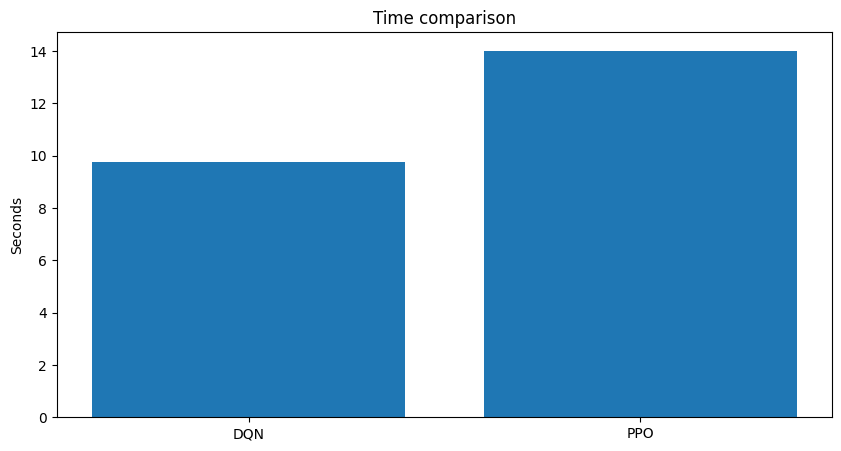

In [116]:
plt.figure(figsize=(10,5))
plt.bar(['DQN','PPO'],[dqn_time,ppo_time])
plt.ylabel('Seconds')
plt.title('Time comparison')

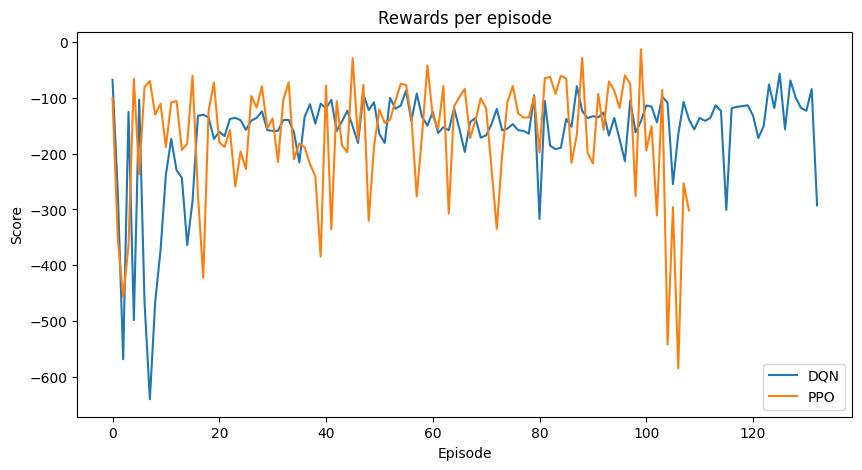

In [117]:
dqn_rewards=dqn_env.get_episode_rewards()
ppo_rewards=ppo_env.get_episode_rewards()

plt.figure(figsize=(10, 5))
plt.plot(dqn_rewards,label='DQN')
plt.plot(ppo_rewards,label='PPO')
plt.title('Rewards per episode')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend()
plt.show()

Let's tune the LunarLander!

Parameters found at https://github.com/DLR-RM/rl-baselines3-zoo/tree/master/hyperparams

In [98]:
steps=200000

In [99]:
dqn_tuned_env= Monitor(gym.make("LunarLander-v3"))
#dqn_tuned=DQN("MlpPolicy",dqn_tuned_env,learning_rate=3e-5, buffer_size=5000,batch_size=64, gamma=0.999, target_update_interval=1000, train_freq=4, gradient_steps=1, exploration_fraction=0.2, exploration_final_eps=0.05)

dqn_tuned=DQN("MlpPolicy",dqn_tuned_env,learning_rate=6.3e-4, buffer_size=50000,batch_size=128, gamma=0.99, target_update_interval=250, train_freq=4, gradient_steps=-1, exploration_fraction=0.12, exploration_final_eps=0.1)

In [100]:
start_time = time.time()
dqn_tuned.learn(total_timesteps=steps)
dqn_time= time.time()-start_time
print(f'DQN took {dqn_time:.2f} secs to tune')
dqn_tuned_rewards=dqn_tuned_env.get_episode_rewards()

DQN took 458.53 secs to tune


In [101]:
ppo_tuned_env =Monitor(gym.make("LunarLander-v3"))

ppo_tuned=PPO("MlpPolicy",ppo_tuned_env,n_steps=1024,batch_size=64,gae_lambda=0.98,gamma=0.999,n_epochs=4,ent_coef=0.01,learning_rate=0.0003)

start_time = time.time()
ppo_tuned.learn(total_timesteps=steps)
ppo_time= time.time()-start_time
print(f'PPO took {ppo_time:.2f} secs to tune')
ppo_tuned_rewards=ppo_tuned_env.get_episode_rewards()

PPO took 173.14 secs to tune


In [102]:
mean_reward_dqn_tuned,_ =evaluate_policy(dqn_tuned, dqn_tuned_env, n_eval_episodes=5)
mean_reward_ppo_tuned,_ =evaluate_policy(ppo_tuned, ppo_tuned_env, n_eval_episodes=5)

print(f"Tuned DQN Mean Reward: {mean_reward_dqn_tuned:.2f}")
print(f"Tune PPO Mean Reward: {mean_reward_ppo_tuned:.2f}")

Tuned DQN Mean Reward: 238.83
Tune PPO Mean Reward: -22.48


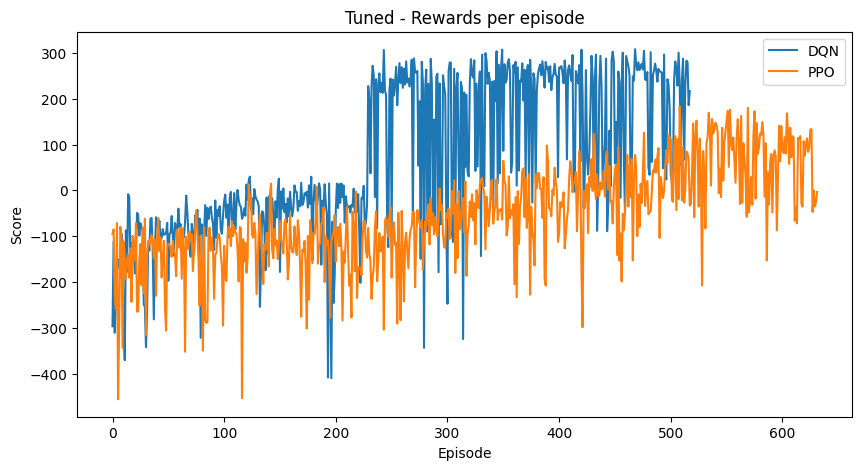

In [103]:
plt.figure(figsize=(10, 5))
plt.plot(dqn_tuned_rewards,label='DQN')
plt.plot(ppo_tuned_rewards,label='PPO')
plt.title('Tuned - Rewards per episode')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend()
plt.show()

We see much higher score, especially for DQN. Let's visualize the environment and see the landing!

In [108]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
env = rl.RenderFrame(env, "./output_ppo_tuned")

socre=0
observation, info = env.reset()
terminated=False
truncated=False

while True:
  #action,_ = ppo_tuned.predict(observation, deterministic=True)
  action,_ = dqn_tuned.predict(observation, deterministic=True)

  observation,reward,terminated,truncated, info= env.step(action)
  score= score+reward

  if terminated or truncated:
    break

print(f'Score = {score:.2f}')
env.play()

Score = -262.54
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


We see that the landing is much better when using the optimal hyperparameters.